In [1]:
# Imports 
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import tjy_udf as tjy
print("tjy_udf: ", list(filter(lambda x: '__' not in x, dir(tjy)))) # Print contained functions
mpl.rc_file('tjy.mplstyle')

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)
DISPLAY_SORTED = True
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib import ticker
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from matplotlib import animation, rc
from scipy.interpolate import UnivariateSpline
    
GIT = 'https://github.com/tyokokur/tmpdat/raw/main/naf/'
''' If SSL error _ssl.c:997: 
    pip install --upgrade certifi'''

tjy_udf:  ['CalcF', 'H_find', 'Heights', 'Kap_D', 'elread', 'get_fp', 'get_fs', 'git_sync', 'lighten_color', 'phread', 'phreadxyz', 'plot_anim', 'plot_pha', 'plot_pha_feed', 'ticks']


' If SSL error _ssl.c:997: \n    pip install --upgrade certifi'

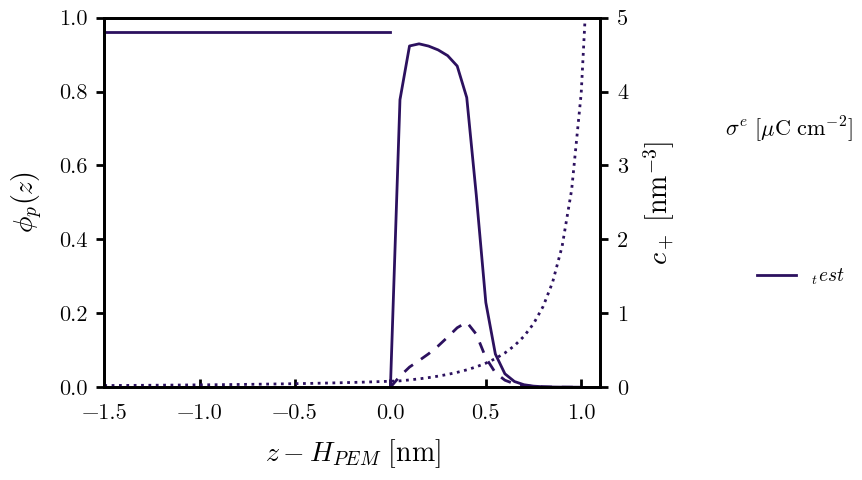

In [2]:
mcs = mpl.colormaps['magma'].resampled(7)(range(5,0,-1))[::-1]
dz = 0.05 ## FIX PLOT SHIFTS IN CODE ITSELF, RIGHT NOW JUST GUESSING
Lz_PEM, phi_PEM = 199.4, 0.96
pat = 'ph'
eat = 'el'
fin = '.dat'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
# for i,c in zip(['10', '5', '0', 'n5', 'n10'],mcs):
for i,c in zip(['_test'],mcs):
    ph = tjy.phread(GIT+pat+i+fin, block=5)
    ax.plot(np.arange(-Lz_PEM,0.0001,0.1), [phi_PEM]*int(round(Lz_PEM/0.10)+1), c=c)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(i))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+fin)
    rax.plot(el.z-Lz_PEM+dz, el.ca,c=c, ls=':')
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z - H_{PEM}\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (-1.5, max(el.z)-Lz_PEM+2*dz),
    ylim= (0, 1),
)    
rax.set(
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (0, 5)
)
ax.text(1.38, 0.68, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.25), ncol=1)

tjy.ticks([ax, rax])

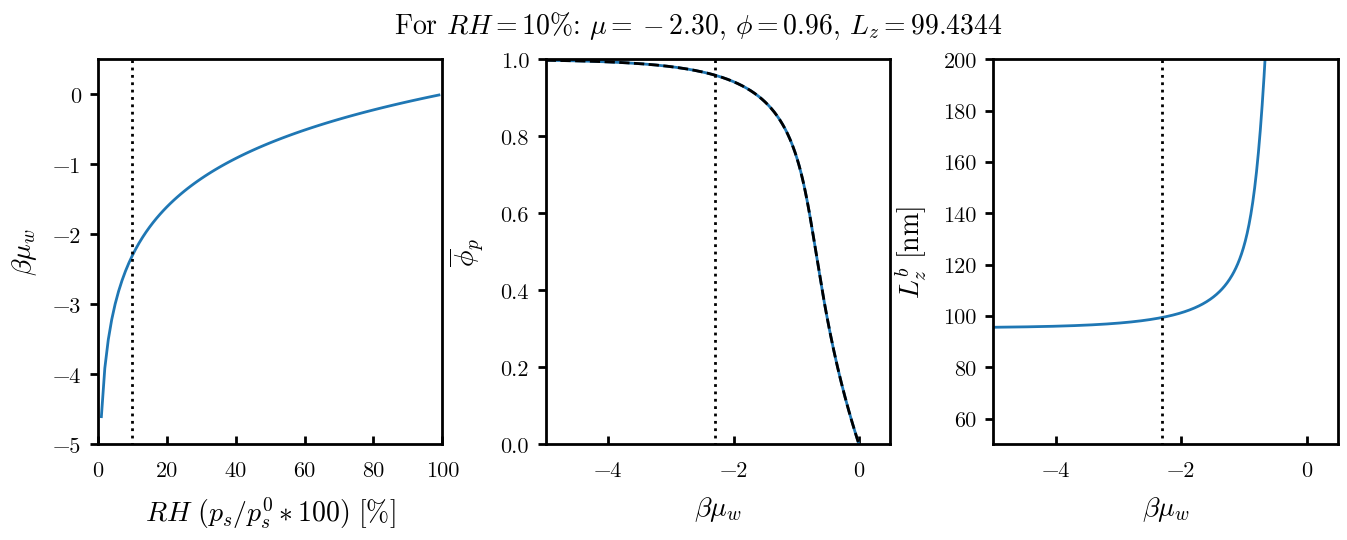

In [13]:
## Inputs
chi = 2.00
patm = 1.0 # ext. pressure = 1 atm
# Print input
RH = 0.1

## Constants
nu = 0.069 #[nm3]
n_p, N, A  = 691, 100, 50 # [1], [1], [nm2]
kT = 1.38e-23 * 293 #[J]
p_kT = patm*101.3 / 1000 * (1e2/1e9)**3 / kT 

mukT_phi = lambda x: np.log(1-x) - x*(1-1/N) + chi*np.power(x,2) + p_kT*nu
mukT_P = lambda x: np.log(x)

fig, axs = plt.subplots(1,3, figsize=(16,5))
plt.subplots_adjust(wspace=0.3)

Ps = np.arange(0.01, 1, 0.01)
axs[0].plot(Ps*100, mukT_P(Ps))

phis = np.arange(0.999,0.00,-0.001)
axs[1].plot(mukT_phi(phis), phis)
fit = UnivariateSpline(mukT_phi(phis), phis, s=1e-12)
mus = np.arange(-5, 0, 0.01)
axs[1].plot(mus, fit(mus),'--k')

axs[2].plot(mus, n_p*N*nu/fit(mus)/A)

mu = mukT_P(RH)
plt.suptitle(r'For $RH = {:.0f}$%: $\mu = {:.2f}$, $\phi = {:.2f}$, $L_z = {:.4f}$'.format(RH*100, mu, fit(mu), n_p*N*nu/fit(mu)/A), fontsize=20, fontfamily='serif')
axs[0].plot([RH*100]*2, [-100,100], ':k')
axs[1].plot([mu]*2, [-100,100], ':k')
axs[2].plot([mu]*2, [0,500], ':k')

axs[0].set(
    xlim= (0,100),
    ylim= (-5,0.5),
    xlabel=r'$RH\ (p_s/p_s^0*100)\ [\%]$',
    ylabel=r'$\beta\mu_w$',
)
axs[1].set(
    xlim= (-5,0.5),
    ylim= (0,1.0),
    xlabel=r'$\beta\mu_w$',
    ylabel=r'$\overline{\phi}_p$',
)
axs[2].set(
    xlim= (-5,0.5),
    ylim= (50, 200),
    ylabel=r'$L_z^b\ [\mathrm{nm}]$',
    xlabel=r'$\beta\mu_w$',
)
tjy.ticks(axs)

# Analytical

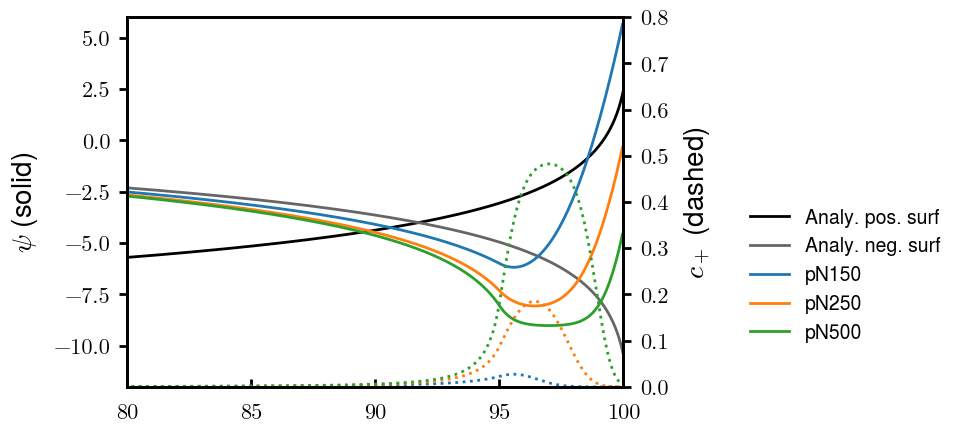

In [44]:
def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': data[1], 'ca': data[2]})
    return el

f,ax = plt.subplots(1,1)
tax = ax.twinx()
el = elread(GIT+'ph_s010_N1000.dat')
ax.plot(el.z, -1*el.psi-8, 'k', label='Analy. pos. surf')
ax.plot(el.z, el.psi, '0.4', label='Analy. neg. surf')
# tax.plot(el.z, el.ca, 'k:')

for i in ['pN150', 'pN250', 'pN500']:
    el = elread(GIT+'ph_sP10_{:s}.dat'.format(i))
    ax.plot(el.z, el.psi, label=i)
    tax.plot(el.z, el.ca, ':')

ax.legend(loc=(1.24,0.1))
ax.set_ylabel(r'$\psi$ (solid)')
tax.set_ylabel(r'$c_+$ (dashed)')
tax.set_ylim(0,0.8)
ax.set_xlim(80,100)
ax.set_ylim(-12,6)
tjy.ticks([ax,tax])

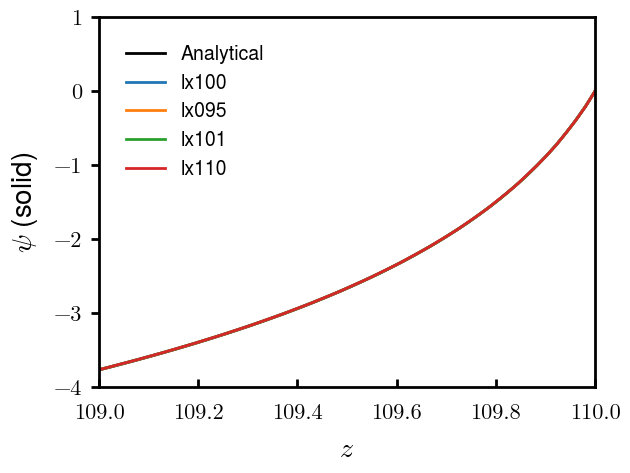

In [95]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

surf_c = 20e-20# C/nm2
lGC = 2*eps0*epsw/(surf_c/e)

fig, ax = plt.subplots(1,1)

psi = lambda z: -2*np.log(1+z/lGC)
z = np.arange(0,110,0.0001)
ax.plot(z[::-1], psi(z), 'k', label='Analytical')

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

shift = lambda el: 110-el.z[len(el.z)-1]
el = elread(GIT+'ph_sN20_RLx100.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C0', label='lx100')
el = elread(GIT+'ph_sN20_RLx095.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C1', label='lx095')
el = elread(GIT+'ph_sN20_RLx101.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C2', label='lx101')
el = elread(GIT+'ph_sN20_RLx110.dat')
ax.plot(el.z+shift(el), el.psi-el.psi[len(el.psi)-1], c='C3', label='lx110')

ax.set_xlim(109,110)
ax.set_xlabel(r'$z$')
ax.set_ylim(-4,1)
ax.set_ylabel(r'$\psi$ (solid)')
ax.legend(loc=2)
tjy.ticks()

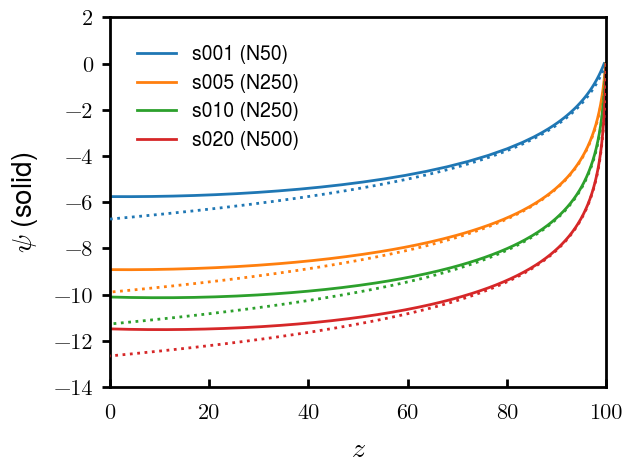

In [99]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el
    
fig, ax = plt.subplots(1,1)
for i,c,lab in zip([1,5,10,20], ['C0', 'C1', 'C2', 'C3'], ['N50', 'N250', 'N250', 'N500']):
    surf_c = i*1e-20# C/nm2
    lGC = 2*eps0*epsw/(surf_c/e)

    psi = lambda z: -2*np.log(1+z/lGC)
    cat = lambda z: 2*eps0*epsw/lGC**2 * np.power((1 + z/lGC), -2)
    z = np.arange(0,100,0.001)
    ax.plot(z[::-1], psi(z), c=c, zorder=5,ls=':')

    ch = 's{0:03d}'.format(int(surf_c*1e20))
    el = elread(GIT+'ph_{:s}_{:s}.dat'.format(ch,lab))
    ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c=c, label='s{:03d} ({:s})'.format(i,lab))

ax.set_xlim(0,100)
ax.set_xlabel(r'$z$')
ax.set_ylim(-14,2)
ax.set_ylabel(r'$\psi$ (solid)')
ax.legend()
tjy.ticks()

lGC = 1.79001e-01
BC = 1.25000e+00
cat(0) = 6.98319e+00
analy. surf_charge err: -2.0547538070836423e-05
numer. surf_charge err: -0.00841489276259182


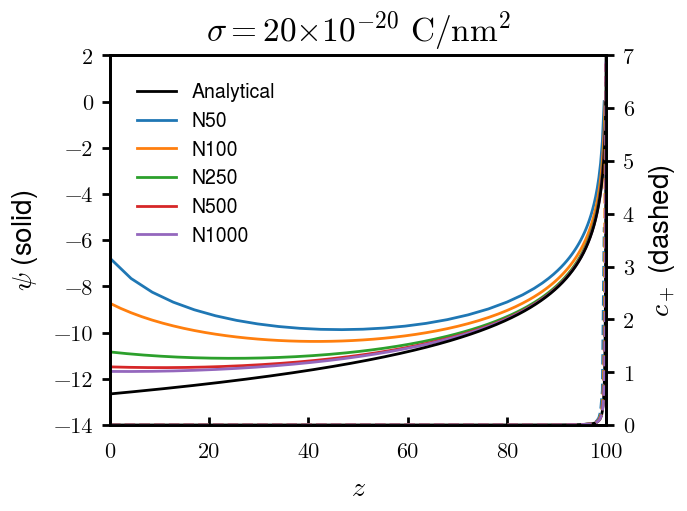

In [82]:
# Analytical 
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*293, 1.6e-19
eps0 *= kBT*1e-09/e/e

surf_c = 20e-20# C/nm2
lGC = 2*eps0*epsw/(surf_c/e)
print("lGC = {:10.5e}".format(lGC), sep='\t')
print("BC = {:10.5e}".format(surf_c/e))

fig, ax = plt.subplots(1,1)
tax = ax.twinx()

psi = lambda z: -2*np.log(1+z/lGC)
cat = lambda z: 2*eps0*epsw/lGC**2 * np.power((1 + z/lGC), -2)
z = np.arange(0,100,0.001)
ax.plot(z[::-1], psi(z), 'k', label='Analytical', zorder=5)
tax.plot(z[::-1], cat(z), 'k')
print("cat(0) = {:10.5e}".format(cat(0)))

def elread(fname):
    data = pd.read_csv(fname, sep="\s+", skiprows=0, header=None)
    el = pd.DataFrame({'z': data[0], 'psi': -1*data[1], 'ca': data[2]})
    return el

lab = 's{0:03d}'.format(int(surf_c*1e20))
el = elread(GIT+'ph_{:s}_N50.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C0', label='N50')
tax.plot(el.z, el.ca, c='C0', ls='--')
el = elread(GIT+'ph_{:s}_N100.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C1', label='N100')
tax.plot(el.z, el.ca, c='C1', ls='--')
el = elread(GIT+'ph_{:s}_N250.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C2', label='N250')
tax.plot(el.z, el.ca, c='C2', ls='--')
el = elread(GIT+'ph_{:s}_N500.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C3', label='N500')
tax.plot(el.z, el.ca, c='C3', ls='--')
el = elread(GIT+'ph_{:s}_N1000.dat'.format(lab))
ax.plot(el.z, el.psi-el.psi[len(el.psi)-1], c='C4', label='N1000')
tax.plot(el.z, el.ca, c='C4', ls='--')

# for i in el.z: plt.plot([i,i], [-10,10], zorder=2, lw=0.1, c='k')

# Error of surface charge boundary condition
print("analy. surf_charge err:", (((-3*psi(z[0]) +4*psi(z[1]) - psi(z[2])) / 2/(z[1] - z[0]) *-eps0*epsw) - surf_c/e)/(surf_c/e) )
print("numer. surf_charge err:", ((-(3*el.psi[len(el.psi)-1] - 4*el.psi[len(el.psi)-2] +el.psi[len(el.psi)-3]) / 2/(el.z[len(el.z)-1] - el.z[len(el.z)-2]) *-eps0*epsw)- surf_c/e)/(surf_c/e) )

plt.title(r'$\sigma={:1.0f}$'.format(surf_c*1e20)+r'$\times 10^{-20}\ \mathrm{C/nm^2}$', fontsize=24)
ax.set_xlim(0,100)
ax.set_xlabel(r'$z$')
ax.set_ylim(-14,2)
ax.set_ylabel(r'$\psi$ (solid)')
tax.set_ylim(0, 7.00)
tax.set_ylabel(r'$c_+$ (dashed)')
ax.legend(loc=0)
tjy.ticks([ax,tax])

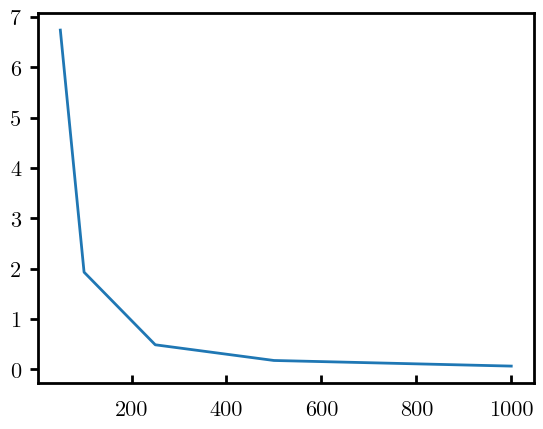

In [217]:
# Harsh analytical solution
## phi = phim + kbT/ze * ln ( cos^2( x/lambda/sqrt(2) ) ), where phim is phi at midplane for bound -q/eps
## lambda = sqrt( eps*kbT / (z^2 e^2 Cm) ), where Cm is midplane concentration where dphi/dz = 0

def get_err(fname):
    eps = 0.11187582375000002
    el = elread(fname)
    Cm = el.ca[0]
    phi = lambda x: np.log( np.power(np.cos( x/lam/np.sqrt(2) ), 2) )
    lam = np.sqrt(eps / Cm)
    
    err = 0
    for i in range(len(el.z)): err += np.power(el.psi[i] + phi(el.z[i]),2)
    return np.sqrt(err)

err = [get_err(GIT+'ph_s001_{:s}.dat'.format(i)) for i in ('N50', 'N100', 'N250', 'N500', 'N1000') ]

plt.plot([50, 100, 250, 500, 1000], err)

plt.yscale('log'
tjy.ticks()

746


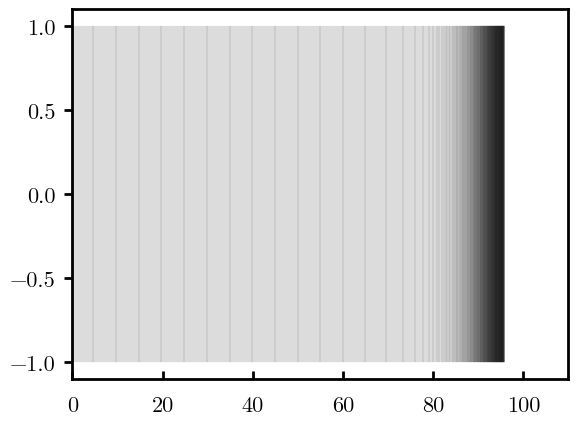

In [73]:
# for i in ['N50', 'N100', 'N250', 'N500', 'N1000']:
for i in ['RLx095']:
    f,ax = plt.subplots(1,1)
    el = elread(GIT+'ph_sN20_{:s}.dat'.format(i))
    for j in el.z: plt.plot([j,j], [-1,1], 'k', lw=0.1)
    print(len(el.z))
    plt.xlim(0,110)
    tjy.ticks()


In [68]:
# Converting wolfram cloud mesh to textfile
data = [0.000,0.019669,0.0392859,0.0588513,0.0783657,0.0978296,0.117244,0.136608,0.155924,0.175191,0.19441,0.213582,0.232707,0.251785,0.270818,0.289805,0.308747,0.327645,0.346498,0.365308,0.384075,0.402799,0.421481,0.440121,0.45872,0.477277,0.495794,0.514271,0.532709,0.551107,0.569466,0.587787,0.606069,0.624314,0.642522,0.660693,0.678827,0.696926,0.714988,0.733016,0.751008,0.768966,0.786889,0.804779,0.822635,0.840458,0.858248,0.876006,0.893732,0.911426,0.929088,0.94672,0.96432,0.981891,0.999431,1.01694,1.03442,1.05187,1.0693,1.08669,1.10406,1.1214,1.13871,1.15599,1.17325,1.19048,1.20769,1.22487,1.24202,1.25915,1.27625,1.29333,1.31038,1.32741,1.34441,1.3614,1.37835,1.39529,1.4122,1.42909,1.44596,1.4628,1.47963,1.49643,1.51321,1.52997,1.54671,1.56343,1.58012,1.5968,1.61346,1.6301,1.64672,1.66332,1.67991,1.69647,1.71302,1.72955,1.74606,1.76255,1.77903,1.79549,1.81193,1.82836,1.84477,1.86116,1.87754,1.8939,1.91025,1.92658,1.9429,1.9592,1.97549,1.99177,2.00803,2.02427,2.04051,2.05673,2.07294,2.08913,2.10531,2.12148,2.13764,2.15379,2.16992,2.18604,2.20215,2.21825,2.23434,2.25042,2.26649,2.28255,2.29859,2.31463,2.33066,2.34668,2.36269,2.37869,2.39468,2.41067,2.42664,2.44261,2.45857,2.47452,2.49046,2.5064,2.52233,2.53825,2.55417,2.57008,2.58598,2.60188,2.61777,2.63365,2.64953,2.6654,2.68127,2.69714,2.713,2.72885,2.7447,2.76055,2.77639,2.79222,2.80806,2.82389,2.83972,2.85554,2.87136,2.88718,2.903,2.91881,2.93463,2.95044,2.96625,2.98205,2.99786,3.01366,3.02947,3.04527,3.06107,3.07688,3.09268,3.10848,3.12428,3.14009,3.15589,3.17169,3.1875,3.20331,3.21911,3.23492,3.25073,3.26655,3.28236,3.29818,3.314,3.32982,3.34565,3.36148,3.37731,3.39314,3.40898,3.42483,3.44067,3.45653,3.47238,3.48824,3.50411,3.51998,3.53585,3.55174,3.56762,3.58351,3.59941,3.61532,3.63123,3.64715,3.66307,3.679,3.69494,3.71089,3.72684,3.74281,3.75878,3.77475,3.79074,3.80674,3.82274,3.83875,3.85478,3.87081,3.88685,3.9029,3.91896,3.93503,3.95112,3.96721,3.98331,3.99943,4.01556,4.03169,4.04784,4.06401,4.08018,4.09637,4.11257,4.12878,4.145,4.16124,4.17749,4.19376,4.21004,4.22633,4.24264,4.25897,4.2753,4.29166,4.30803,4.32441,4.34081,4.35723,4.37366,4.39011,4.40657,4.42305,4.43955,4.45607,4.47261,4.48916,4.50573,4.52232,4.53893,4.55556,4.5722,4.58887,4.60556,4.62226,4.63899,4.65573,4.6725,4.68929,4.7061,4.72293,4.73978,4.75666,4.77356,4.79048,4.80742,4.82439,4.84138,4.85839,4.87543,4.89249,4.90958,4.92669,4.94383,4.96099,4.97818,4.99539,5.01263,5.0299,5.04719,5.06451,5.08186,5.09924,5.11664,5.13408,5.15154,5.16903,5.18655,5.20411,5.22169,5.2393,5.25694,5.27462,5.29232,5.31006,5.32783,5.34563,5.36346,5.38133,5.39923,5.41717,5.43514,5.45315,5.47119,5.48926,5.50737,5.52552,5.5437,5.56193,5.58018,5.59848,5.61682,5.63519,5.6536,5.67205,5.69054,5.70908,5.72765,5.74626,5.76492,5.78361,5.80235,5.82114,5.83996,5.85883,5.87775,5.8967,5.91571,5.93476,5.95385,5.97299,5.99218,6.01142,6.0307,6.05004,6.06942,6.08885,6.10833,6.12787,6.14745,6.16709,6.18678,6.20652,6.22631,6.24616,6.26606,6.28602,6.30603,6.3261,6.34623,6.36641,6.38666,6.40696,6.42732,6.44774,6.46822,6.48876,6.50937,6.53003,6.55076,6.57156,6.59242,6.61334,6.63433,6.65539,6.67651,6.6977,6.71896,6.7403,6.7617,6.78317,6.80472,6.82633,6.84803,6.86979,6.89163,6.91355,6.93554,6.95762,6.97977,7.002,7.02431,7.0467,7.06918,7.09173,7.11438,7.1371,7.15992,7.18282,7.20581,7.22888,7.25205,7.27531,7.29866,7.32211,7.34565,7.36928,7.39301,7.41684,7.44077,7.4648,7.48893,7.51316,7.5375,7.56194,7.58649,7.61115,7.63591,7.66079,7.68577,7.71087,7.73609,7.76142,7.78687,7.81243,7.83812,7.86393,7.88986,7.91592,7.9421,7.96841,7.99485,8.02142,8.04813,8.07497,8.10195,8.12906,8.15632,8.18372,8.21126,8.23895,8.26678,8.29477,8.32291,8.3512,8.37965,8.40826,8.43702,8.46595,8.49505,8.52431,8.55374,8.58334,8.61312,8.64308,8.67321,8.70353,8.73403,8.76472,8.7956,8.82667,8.85794,8.8894,8.92107,8.95294,8.98502,9.01732,9.04982,9.08254,9.11549,9.14866,9.18205,9.21568,9.24954,9.28364,9.31799,9.35258,9.38742,9.42251,9.45786,9.49348,9.52936,9.56552,9.60195,9.63866,9.67566,9.71294,9.75052,9.78841,9.82659,9.86509,9.90391,9.94304,9.98251,10.0223,10.0624,10.1029,10.1438,10.1849,10.2265,10.2684,10.3107,10.3534,10.3965,10.44,10.4839,10.5282,10.5729,10.6181,10.6637,10.7097,10.7562,10.8032,10.8506,10.8986,10.947,10.9959,11.0454,11.0954,11.1459,11.1969,11.2485,11.3007,11.3535,11.4069,11.4608,11.5154,11.5707,11.6265,11.6831,11.7403,11.7982,11.8568,11.9162,11.9763,12.0371,12.0987,12.1611,12.2243,12.2884,12.3532,12.419,12.4856,12.5532,12.6216,12.691,12.7614,12.8328,12.9052,12.9786,13.0531,13.1287,13.2054,13.2832,13.3623,13.4424,13.5239,13.6065,13.6905,13.7757,13.8623,13.9503,14.0396,14.1304,14.2226,14.3163,14.4116,14.5084,14.6068,14.7068,14.8084,14.9118,15.0168,15.1236,15.2322,15.3425,15.4547,15.5688,15.6848,15.8027,15.9225,16.0444,16.1682,16.294,16.4219,16.5518,16.6838,16.8179,16.9541,17.0925,17.2329,17.3754,17.5201,17.6669,17.8158,17.9668,18.1199,18.275,18.4322,18.5915,18.7528,18.9161,19.0813,19.2484,19.4175,19.5883,19.761,19.9355,20.1117,20.2895,20.469,20.6501,20.8327,21.0168,21.2023,21.3892,21.5774,21.7668,21.9575,22.1494,22.3424,22.5365,22.7316,22.9277,23.1247,23.3226,23.5213,23.7209,23.9212,24.1222,24.3239,24.5262,24.7292,24.9327,25.1368,25.3414,25.5464,25.752,25.9579,26.1643,26.371,26.5781,26.7856,26.9933,27.2014,27.4097,27.6183,27.8272,28.0362,28.2455,28.455,28.6647,28.8746,29.0846,29.2948,29.5051,29.7156,29.9261,30.1369,30.3477,30.5586,30.7696,30.9808,31.192,31.4032,31.6146,31.826,32.0375,32.2491,32.4607,32.6724,32.8841,33.0958,33.3076,33.5195,33.7314,33.9433,34.1553,34.3672,34.5793,34.7913,35.0034,35.2155,35.4276,35.6397,35.8518,36.064,36.2762,36.4884,36.7006,36.9129,37.1251,37.3374,37.5496,37.7619,37.9742,38.1865,38.3988,38.6111,38.8234,39.0358,39.2481,39.4604,39.6728,39.8851,40.0975,40.3098,40.5222,40.7346,40.9469,41.1593,41.3717,41.5841,41.7965,42.0088,42.2212,42.4336,42.646,42.8584,43.0708,43.2832,43.4956,43.708,43.9204,44.1328,44.3452,44.5576,44.7701,44.9825,45.1949,45.4073,45.6197,45.8321,46.0445,46.2569,46.4694,46.6818,46.8942,47.1066,47.319,47.5314,47.7439,47.9563,48.1687,48.3811,48.5935,48.806,49.0184,49.2308,49.4432,49.6556,49.8681,50.0805,50.2929,50.5053,50.7177,50.9302,51.1426,51.355,51.5674,51.7799,51.9923,52.2047,52.4171,52.6296,52.842,53.0544,53.2668,53.4792,53.6917,53.9041,54.1165,54.3289,54.5414,54.7538,54.9662,55.1786,55.3911,55.6035,55.8159,56.0283,56.2407,56.4532,56.6656,56.878,57.0904,57.3029,57.5153,57.7277,57.9401,58.1526,58.365,58.5774,58.7898,59.0023,59.2147,59.4271,59.6395,59.852,60.0644,60.2768,60.4892,60.7017,60.9141,61.1265,61.3389,61.5513,61.7638,61.9762,62.1886,62.401,62.6135,62.8259,63.0383,63.2507,63.4632,63.6756,63.888,64.1004,64.3129,64.5253,64.7377,64.9501,65.1626,65.375,65.5874,65.7998,66.0123,66.2247,66.4371,66.6495,66.8619,67.0744,67.2868,67.4992,67.7116,67.9241,68.1365,68.3489,68.5613,68.7738,68.9862,69.1986,69.411,69.6235,69.8359,70.0483,70.2607,70.4732,70.6856,70.898,71.1104,71.3229,71.5353,71.7477,71.9601,72.1726,72.385,72.5974,72.8098,73.0222,73.2347,73.4471,73.6595,73.8719,74.0844,74.2968,74.5092,74.7216,74.9341,75.1465,75.3589,75.5713,75.7838,75.9962,76.2086,76.421,76.6335,76.8459,77.0583,77.2707,77.4832,77.6956,77.908,78.1204,78.3329,78.5453,78.7577,78.9701,79.1825,79.395,79.6074,79.8198,80.0322,80.2447,80.4571,80.6695,80.8819,81.0944,81.3068,81.5192,81.7316,81.9441,82.1565,82.3689,82.5813,82.7938,83.0062,83.2186,83.431,83.6435,83.8559,84.0683,84.2807,84.4932,84.7056,84.918,85.1304,85.3428,85.5553,85.7677,85.9801,86.1925,86.405,86.6174,86.8298,87.0422,87.2547,87.4671,87.6795,87.8919,88.1044,88.3168,88.5292,88.7416,88.9541,89.1665,89.3789,89.5913,89.8038,90.0162,90.2286,90.441,90.6534,90.8659,91.0783,91.2907,91.5031,91.7156,91.928,92.1404,92.3528,92.5653,92.7777,92.9901,93.2025,93.415,93.6274,93.8398,94.0522,94.2647,94.4771,94.6895,94.9019,95.1144,95.3268,95.5392,95.7516,95.9641,96.1765,96.3889,96.6013,96.8137,97.0262,97.2386,97.451,97.6634,97.8759,98.0883,98.3007,98.5131,98.7256,98.938,99.1504,99.3628,99.5753,99.7877,100.]  
df = pd.DataFrame(data,columns=['read'])
df.to_csv('test.txt',index=False,header=False)

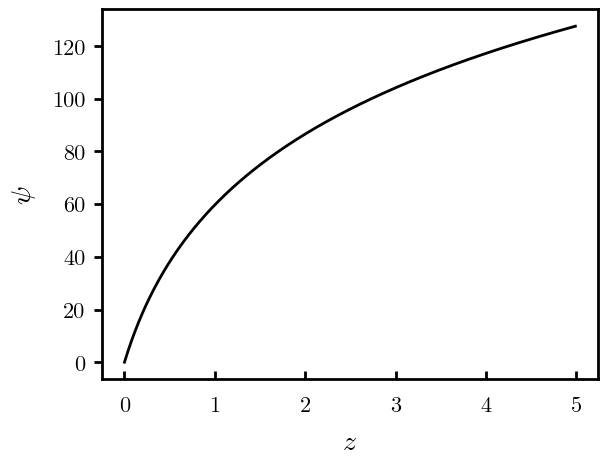

In [14]:
# Analytical, compare with 'soft condensed matter...' textbook, andelman chapter
eps0, epsw, kBT, e = 8.854e-12, 80, 1.38e-23*298, 1.6e-19
A = 1

surf_c = -e/2e-09 # C/nm2

lGC = 2*eps0*epsw*kBT/e/abs(surf_c)
psi0 = -2*np.log(lGC)

psi = lambda z: 2*np.log(z+lGC)+psi0
z = np.arange(0,5,0.01)
plt.plot(z, psi(z)*25.7, 'k')

plt.ylabel(r'$\psi$')
plt.xlabel(r'$z$')
tjy.ticks()

# PREV

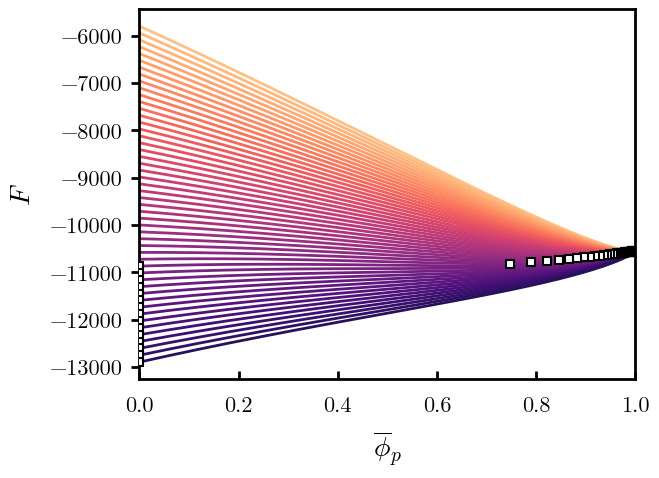

In [2]:
mcs = mpl.colormaps['magma'].resampled(70)(range(60,0,-1))
ccycle = iter(mcs)

def Solve_SCF(mu_w, n_p, N, V, nu):
    chi = 1.00
    
    phi_p = n_p*N*nu/V
    phi_w = 1-phi_p
    w_w   = mu_w - np.log(phi_w)
    eta   = chi*phi_p - w_w
    w_p   = chi*phi_w - eta
    Q_w   = V/nu * np.exp(-w_w)
    Q_p   = V/nu * np.exp(-w_p)
    
    f = -np.exp(mu_w)*Q_w - n_p*N*np.log(Q_p) + V/nu*(chi*phi_p*phi_w - w_p*phi_p - w_w*phi_w) #+ np.log(float(np.math.factorial(int(n_p))))
    return phi_p, f

zeros = []
mu_ws = np.arange(3.00, 8.00, 0.10)
for mu_w in mu_ws:
    N, V, nu = 50, 100, 0.069 # [1], [nm3], [nm3]

    phi_ps, fs = [], []
    for n_p in np.arange(0,V/(nu*N),0.05):
        phi_p, f = Solve_SCF(mu_w, n_p, N, V, nu)
        phi_ps.append(phi_p)
        fs.append(f)
    curve = UnivariateSpline(phi_ps, fs, s=1e-04, k=4)
    zero = curve.derivative(1).roots()
    left, right = float(curve(0)), float(curve(1)) # Extremeties
    fil = lambda x: x[np.argmin(curve(x))] # Find location of minimum
    if    zero.size==1: zero = fil([0,1,zero[0]])
    elif  zero.size==2: zero = fil([0,1,zero[0],zero[1]])
    else: zero = fil([0,1])
    zeros.append(zero)

    plt.plot(phi_ps, curve(phi_ps), label='_'+str(mu_w), c=next(ccycle))
    plt.plot(zero, curve(zero), 's', markerfacecolor='white', c='k', zorder=5)

# plt.legend(loc=(1.07,0.05), title=r'$\mu_w$', title_fontsize=20, ncols=2)
plt.xlim(0.0,1.0)
plt.xlabel(r'$\overline{\phi}_p$')
plt.ylabel(r'$F$')
tjy.ticks()

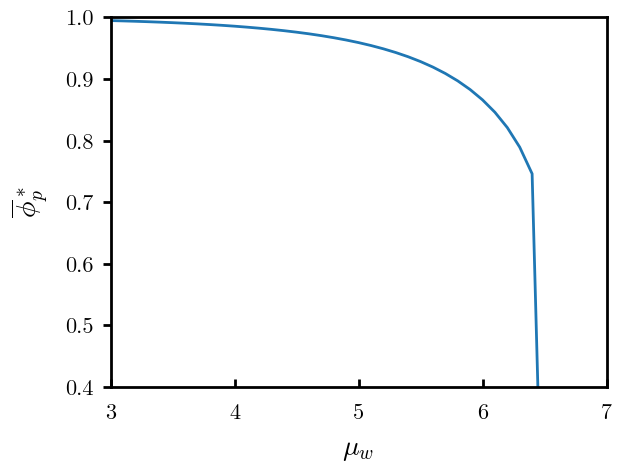

In [4]:
plt.plot(mu_ws, zeros)

plt.ylim(0.4,1)
plt.xlim(3.00, 7.00)
plt.xlabel(r'$\mu_w$')
plt.ylabel(r'$\overline{\phi}_p^*$')
tjy.ticks()

In [2]:
def Process(fname):
    data = pd.read_csv(fname, names=np.arange(12), sep='\s+')
    thetas, nd = [], []
    for i in range(len(data)):
        if i%2: thetas += [data.iloc[i,5]] # Vol dens of block 2 adj. to surf
        else:   nd += [data.iloc[i,:6].to_list()]
    return pd.concat([pd.DataFrame(nd,  columns=['it', 'lx', 'free', 'freeDiff', 'inCompMax', 'andErr']), pd.Series(thetas, name='theta')], axis=1)

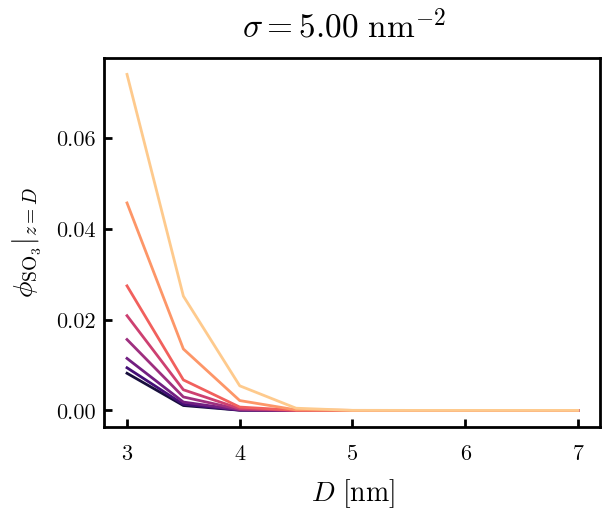

In [23]:
lx30, lx35, lx40, lx45 = Process(GIT+'s500_lx30.txt'), Process(GIT+'s500_lx35.txt'), Process(GIT+'s500_lx40.txt'), Process(GIT+'s500_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s500_lx50.txt'), Process(GIT+'s500_lx55.txt'), Process(GIT+'s500_lx60.txt'), Process(GIT+'s500_lx65.txt'), Process(GIT+'s500_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

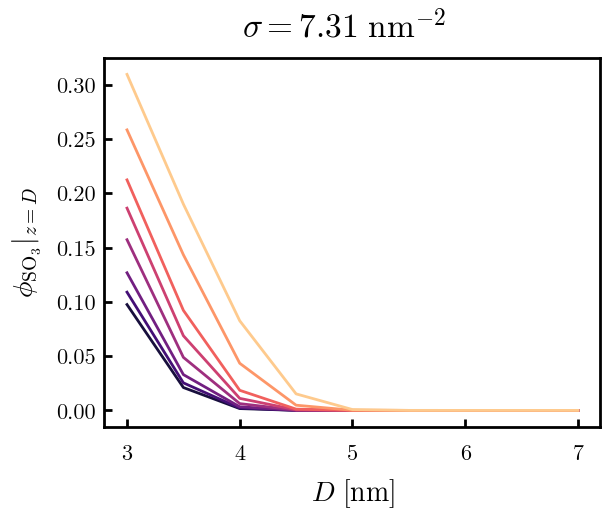

In [22]:
lx30, lx35, lx40, lx45 = Process(GIT+'s731_lx30.txt'), Process(GIT+'s731_lx35.txt'), Process(GIT+'s731_lx40.txt'), Process(GIT+'s731_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s731_lx50.txt'), Process(GIT+'s731_lx55.txt'), Process(GIT+'s731_lx60.txt'), Process(GIT+'s731_lx65.txt'), Process(GIT+'s731_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

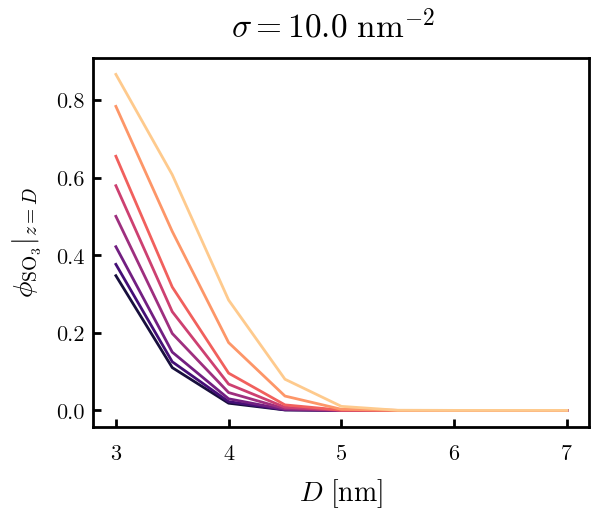

In [21]:
lx30, lx35, lx40, lx45 = Process(GIT+'s1000_lx30.txt'), Process(GIT+'s1000_lx35.txt'), Process(GIT+'s1000_lx40.txt'), Process(GIT+'s1000_lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+'s1000_lx50.txt'), Process(GIT+'s1000_lx55.txt'), Process(GIT+'s1000_lx60.txt'), Process(GIT+'s1000_lx65.txt'), Process(GIT+'s1000_lx70.txt')

lxs = [lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

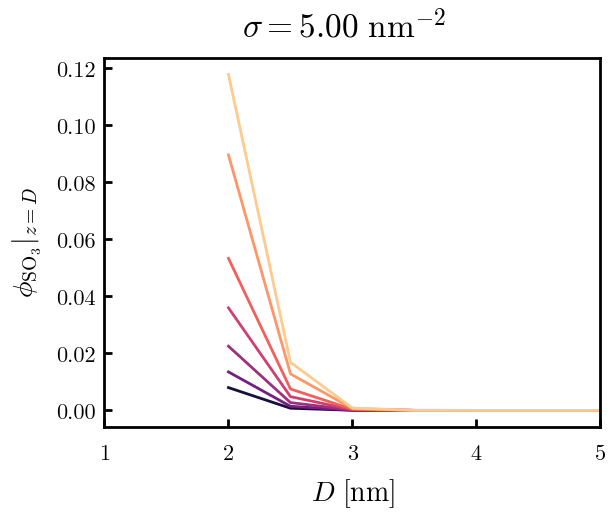

In [45]:
cs = 'c100_'
ss = 's500_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim = (1, 5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=5.00\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

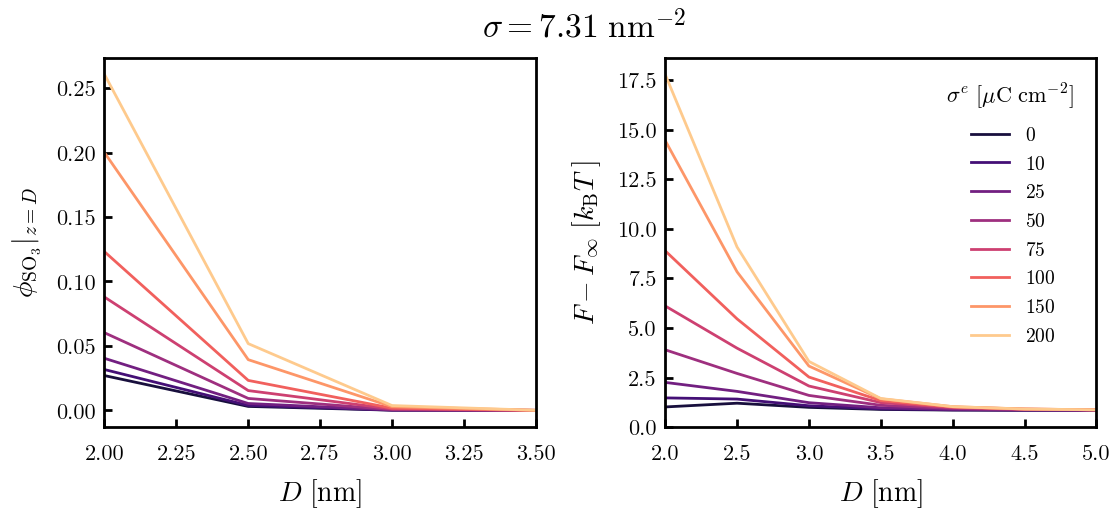

In [187]:
cs,cbulk = 'c100_', 0.1 * 1000 * 6.02e23 / 1e27 *2
ss = 's731_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,2, figsize=(mpl.rcParams['figure.figsize'][0]*2, mpl.rcParams['figure.figsize'][1]))
# ax = [ax]
plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    ax[1].plot(x, y-y[-1] + cbulk*x, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (2, 3.5)
    # yscale= 'log',
    # ylim= (1e-09, 1.0)
)
ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
ax[1].legend(loc=(0.69,0.20), ncol=1)

ax[1].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim= (2, 5)
)
plt.suptitle(r'$\sigma=7.31\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

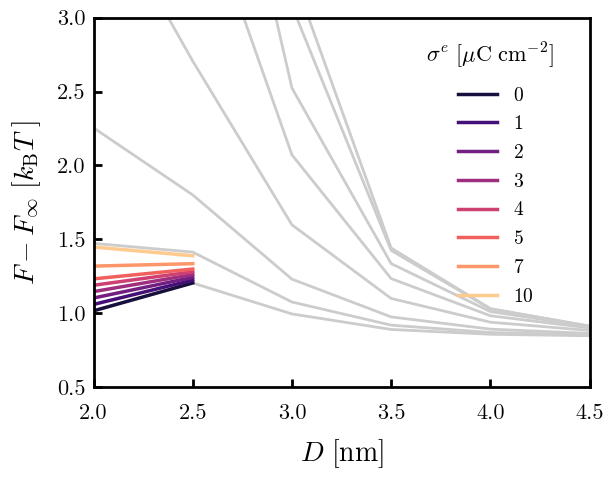

In [127]:
bulk = lx70
for ind,i in enumerate(surfs):
    x = np.array([i.lx[0] for i in lxs])
    y = [i.free[ind] for i in lxs]
    plt.plot(x, y-bulk.free[ind] + cbulk*x, label='_${}$'.format(i), color='0.8')
    
kws = {'names':['it', 'lx', 'free', 'x', 'xx', 'xxx'], 'sep':'\s+'}
data = pd.read_csv(GIT+'new-lx15.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data1= pd.read_csv(GIT+'new-lx20.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')
data2= pd.read_csv(GIT+'new-lx25.txt', **kws)#names=['it', 'lx', 'freeE', 'x', 'xx', 'xxx'], sep='\s+')

for ind,i in enumerate([0,1,2,3,4,5,7,10]):
    x=np.array([i.lx[0] for i in [data, data1, data2]])[1:3]
    y=[i.free[ind] for i in [data,data1,data2]][1:3]
    plt.plot(x,y-bulk.free[0]+cbulk*x, label='${}$'.format(i), color=mcs[ind], marker='', lw=2.5)
    
plt.gca().set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlim=(2,4.5),
    ylim=(0.5,3)
)
plt.text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=plt.gca().transAxes, fontsize=16, ha='center')
plt.legend(loc=(0.72,0.2))
tjy.ticks()

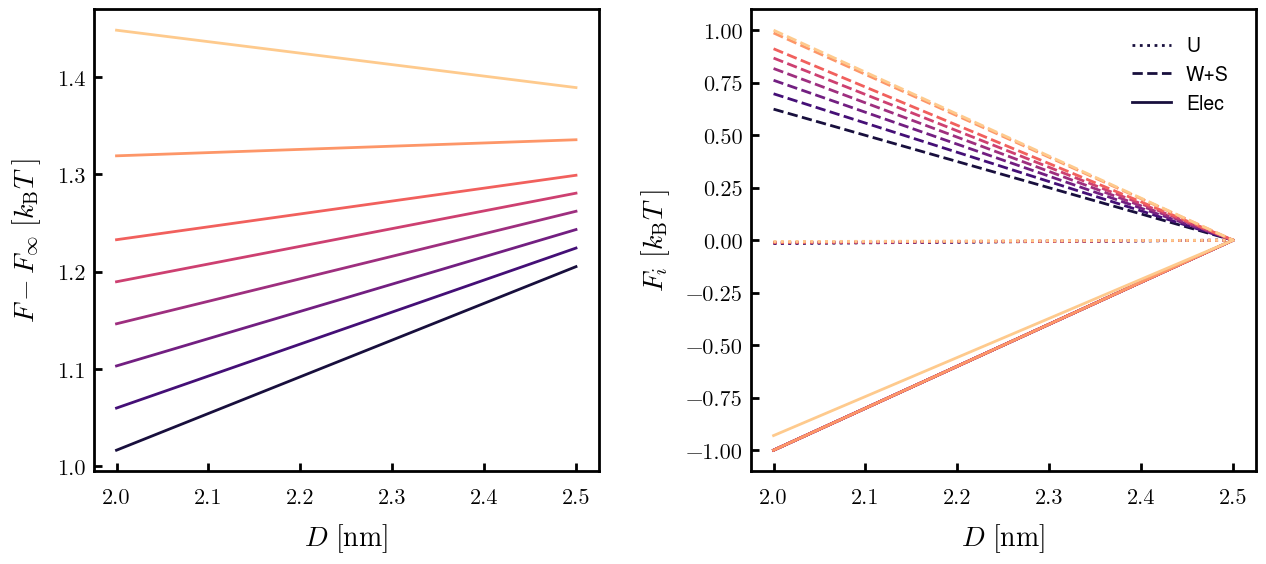

In [185]:
lx25fs = pd.DataFrame([
    [0,  2.500e+00, -4.70644e+01, 1.42445e-01, -5.70074e+01, -1.00664e+01, 2.01681e+01, -3.01100e-01],
    [1,  2.500e+00, -4.70453e+01, 1.42697e-01, -5.69071e+01, -1.01076e+01, 2.01279e+01, -3.01100e-01],
    [2,  2.500e+00, -4.70263e+01, 1.42951e-01, -5.68055e+01, -1.01494e+01, 2.00867e+01, -3.01100e-01],
    [3,  2.500e+00, -4.70075e+01, 1.43208e-01, -5.67026e+01, -1.01915e+01, 2.00445e+01, -3.01100e-01],
    [4,  2.500e+00, -4.69889e+01, 1.43469e-01, -5.65984e+01, -1.02342e+01, 2.00013e+01, -3.01100e-01],
    [5,  2.500e+00, -4.69705e+01, 1.43732e-01, -5.64929e+01, -1.02772e+01, 1.99570e+01, -3.01100e-01],
    [7,  2.500e+00, -4.69340e+01, 1.44269e-01, -5.62778e+01, -1.03647e+01, 1.98653e+01, -3.01100e-01],
    [10, 2.500e+00, -4.68804e+01, 1.45097e-01, -5.59451e+01, -1.04994e+01, 1.97200e+01, -3.01100e-01],
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])
lx20fs = pd.DataFrame([
    [0,  2.000e+00, -4.71928e+01, 1.34811e-01, -7.39004e+01, 7.12726e+00, 1.96863e+01, -2.40880e-01],
    [1,  2.000e+00, -4.71495e+01, 1.35207e-01, -7.36954e+01, 7.04242e+00, 1.96091e+01, -2.40880e-01],
    [2,  2.000e+00, -4.71062e+01, 1.35607e-01, -7.34882e+01, 6.95684e+00, 1.95305e+01, -2.40880e-01],
    [3,  2.000e+00, -4.70629e+01, 1.36010e-01, -7.32789e+01, 6.87055e+00, 1.94503e+01, -2.40880e-01],
    [4,  2.000e+00, -4.70197e+01, 1.36418e-01, -7.30675e+01, 6.78354e+00, 1.93687e+01, -2.40880e-01],
    [5,  2.000e+00, -4.69765e+01, 1.36829e-01, -7.28539e+01, 6.69581e+00, 1.92856e+01, -2.40880e-01],
    [7,  2.000e+00, -4.68903e+01, 1.37662e-01, -7.24202e+01, 6.51825e+00, 1.91149e+01, -2.40880e-01],
    [10, 2.000e+00, -4.67612e+01, 1.38939e-01, -7.17533e+01, 6.24658e+00, 1.88475e+01, -2.40880e-01], 
], columns=['surf', 'lx', 'free', 'U', 'W', 'S', 'elec', 'bulk'])

lxfs = [lx20fs, lx25fs]
end = 1
rel = lambda x: np.array(x) - x[end]
fig, axs = plt.subplots(1,2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.3)
for ind,i in enumerate(lx25fs.surf):
    x = [i.lx[0] for i in lxfs]
    y0= [i.free[ind]-i.bulk[ind]-bulk.free[0] for i in lxfs]
    axs[0].plot(x,y0, label='${}$'.format(i), color=mcs[ind])
    
    rU, rWS, rE = rel([i.U[ind] for i in lxfs]), rel([i.W[ind]+i.S[ind] for i in lxfs]), rel([i.elec[ind] for i in lxfs])
    maxm = np.max([np.max(np.abs(rU)), np.max(np.abs(rWS)), np.max(np.abs(rE))])
    if maxm!=0: 
        axs[1].plot(x,rU/maxm, color=mcs[ind], ls=':', label='U')
        axs[1].plot(x,rWS/maxm,color=mcs[ind], ls='--', label='W+S')
        axs[1].plot(x,rE/maxm, color=mcs[ind], label='Elec')
    
axs[0].set(
    ylabel= r'$F-F_{\infty}\ [k_\mathrm{B}T\ ]$', 
    xlabel=r'$D\ [\mathrm{nm}]$'
)
axs[1].set(
    ylim=(-1.1,1.1),
    ylabel=r'$F_i\ [k_\mathrm{B}T\ ]$',
    xlabel=r'$D\ [\mathrm{nm}]$'
)
h, l = axs[1].get_legend_handles_labels()
axs[1].legend(handles=h[:3], labels=l[:3])
tjy.ticks(axs)

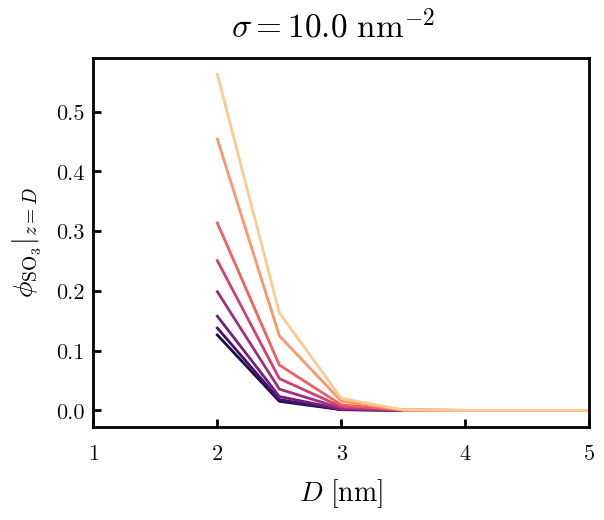

In [48]:
cs = 'c100_'
ss = 's1000_'
lx20, lx25 = Process(GIT+cs+ss+'lx20.txt'), Process(GIT+cs+ss+'lx25.txt')
lx30, lx35, lx40, lx45 = Process(GIT+cs+ss+'lx30.txt'), Process(GIT+cs+ss+'lx35.txt'), Process(GIT+cs+ss+'lx40.txt'), Process(GIT+cs+ss+'lx45.txt')
lx50, lx55, lx60, lx65, lx70 = Process(GIT+cs+ss+'lx50.txt'), Process(GIT+cs+ss+'lx55.txt'), Process(GIT+cs+ss+'lx60.txt'), Process(GIT+cs+ss+'lx65.txt'), Process(GIT+cs+ss+'lx70.txt')

lxs = [lx20, lx25, lx30, lx35, lx40, lx45, lx50, lx55, lx60, lx65, lx70]
surfs = [0, 10, 25, 50, 75, 100, 150, 200]
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
vcs = mpl.colormaps['viridis'].resampled(9)(range(7,0,-1))

fig, ax = plt.subplots(1,1, figsize=(mpl.rcParams['figure.figsize'][0]*1, mpl.rcParams['figure.figsize'][1]))
ax = [ax]
# plt.subplots_adjust(wspace=0.3)
    
for ind,i in enumerate(surfs):
    x = [i.lx[0] for i in lxs]
    y = [i.free[ind] for i in lxs]
    # ax[1].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
    x = [i.lx[0] for i in lxs]
    y = [i.theta[ind] for i in lxs]
    ax[0].plot(x, y, label='${}$'.format(i), color=mcs[ind])
    
ax[0].set(
    xlabel= r'$D\ [\mathrm{nm}]$',
    ylabel= r'$\phi_{\mathrm{SO_3}}\vert_{z=D}$',
    xlim= (1, 5),
    # yscale= 'log',
    # ylim= (1e-03, 1.0)
)
# ax[1].text(0.80, 0.88, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax[1].transAxes, fontsize=16, ha='center')
# ax[1].legend(loc=(0.69,0.20), ncol=1)

# ax[1].set(
#     xlabel= r'$D\ [\mathrm{nm}]$',
#     ylabel= r'$F\ [k_\mathrm{B}T\ ]$', 
# )
plt.suptitle(r'$\sigma=10.0\ \mathrm{nm}^{-2}$', fontsize=24)
tjy.ticks(ax)

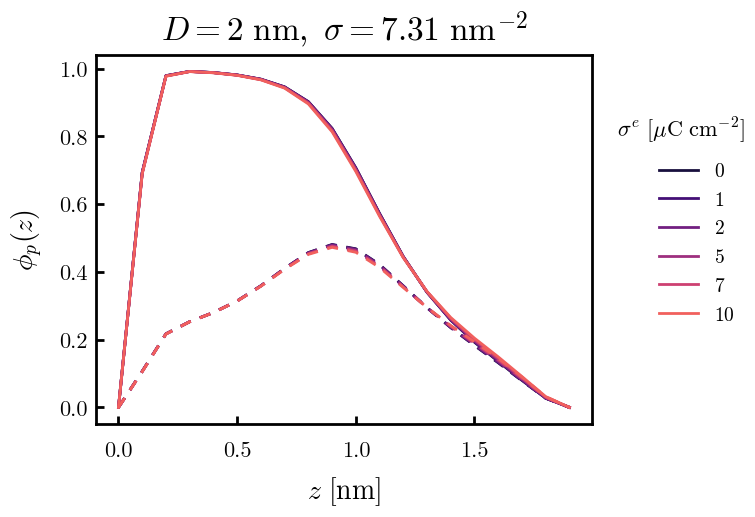

In [93]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'ph_new-lx200e'

fig, ax = plt.subplots(1,1)
for i,c in zip(['000', '001', '002', '005', '007', '010'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
    
# ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
# ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
#             arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    # xlim= (1.4, 1.8),
    # ylim= (0, 0.30),
)    

ax.text(1.18, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.12,0.25), ncol=1)

plt.title(r'$D=2\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks()

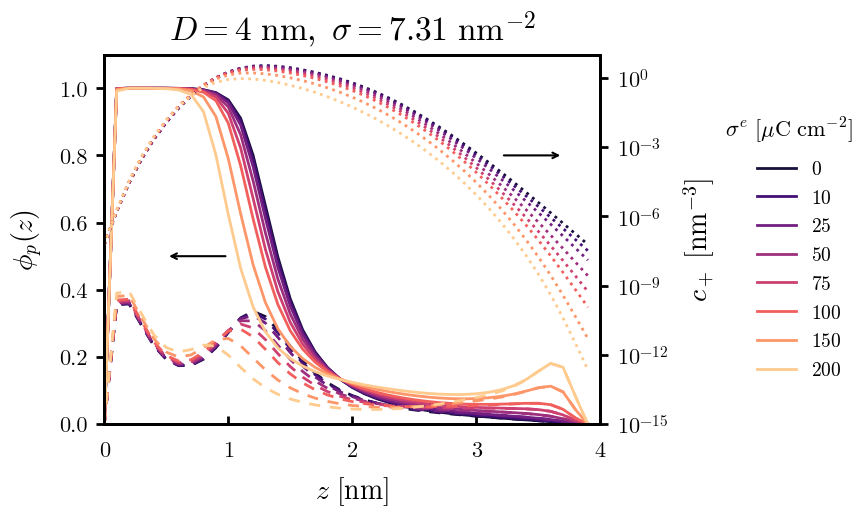

In [3]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731_lx400e'
eat = 'els731_lx400e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.5, 0.5), xytext=(1.0, 0.5),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(3.7, 0.8), xytext=(3.2, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 4),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-15, 1e1)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=4\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])

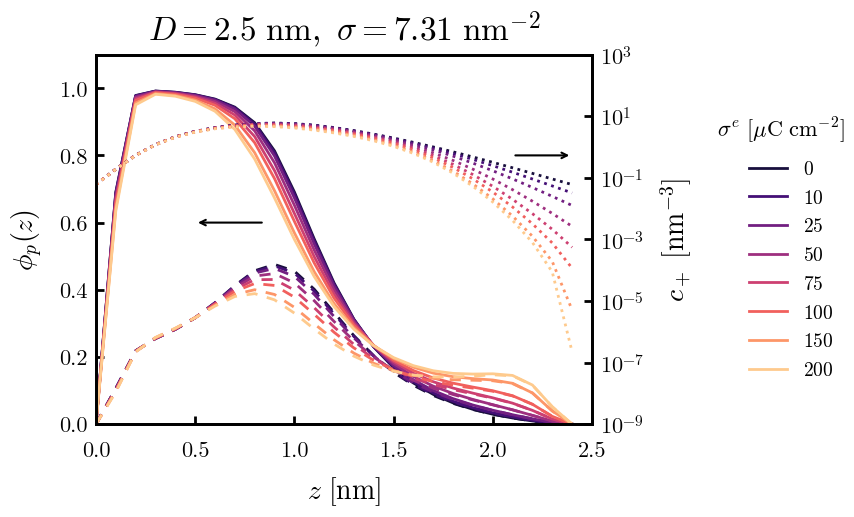

In [77]:
mcs = mpl.colormaps['magma'].resampled(10)(range(8,0,-1))[::-1]
pat = 'phs731c100_lx250e'
eat = 'els731c100_lx250e'

fig, ax = plt.subplots(1,1)
rax = ax.twinx()
for i,c in zip(['000', '010', '025', '050', '075', '100', '150', '200'],mcs):
    ph = tjy.phread(GIT+pat+i+'.dat', block=5)
    ax.plot(ph.z, ph.overall, ls='-', c=c, label=r'${:}$'.format(int(i)))
    ax.plot(ph.z, ph.block5, ls=(0,(4,3.5)), c=c)
   
    el = tjy.elread(GIT+eat+i+'.dat')
    rax.plot(el.z, el.an,c=c, ls=':')
    
ax.annotate("", xy=(0.50, 0.6), xytext=(0.85, 0.6),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.annotate("", xy=(2.4, 0.8), xytext=(2.1, 0.8),
            arrowprops=dict(arrowstyle="->", linewidth=1.5))
ax.set(
    xlabel= '$z\ [\mathrm{nm}]$',
    ylabel= '$\phi_p(z)$',
    xlim= (0, 2.5),
    ylim= (0, 1.10),
)    
rax.set(
    yscale='log',
    ylabel= '$c_+\ [\mathrm{nm}^{-3}]$',
    ylim= (1e-9, 1e3)
)
ax.text(1.38, 0.78, r'$\sigma^e\ [\mu \mathrm{C}\ \mathrm{cm}^{-2}]$', transform=ax.transAxes, fontsize=16, ha='center')
ax.legend(loc=(1.30,0.10), ncol=1)

plt.title(r'$D=2.5\ \mathrm{nm},\ \sigma=7.31\ \mathrm{nm}^{-2}$')
tjy.ticks([ax, rax])